# Code

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from ConfigParser import SafeConfigParser
from operator import add
from pyspark.mllib.recommendation import ALS, Rating
import random 
from random import randint
import itertools
from math import sqrt
import numpy as np
from pprint import pprint
import math
from ConfigParser import SafeConfigParser
import pandas as pd


def get_parser(names):
    def loadRecord(line):
        cells = line.strip().split('\t')
        return dict(zip(names, cells))
    return loadRecord

def get_lang2id_maps(languages):
    lang2id = {}
    id2lang = {}
    for i, lang in enumerate(languages):
        lang2id[lang] = i
        id2lang[i] = lang
    return lang2id, id2lang

def toRating(x):
    user_id = lang2id[x['lang']]
    item_id=int(x['id'][1:])
    counts = float(x['pageview_count'])
    return (user_id, item_id, counts)

def load_pageviews(sc, filename, k=3):
    names = [ 'id', 'lang', 'title', 'pageview_count']
    pageviews = sc.textFile(filename)\
    .map(get_parser(names))\
    .filter(lambda x: len(x) == 4)\
    .filter(lambda x: x['lang'] in languages_set)\
    .map(lambda x: (x['id'], x))\
    .groupByKey().filter(lambda x: len(x[1]) >=k ).flatMap(lambda x: x[1])\
    .filter(lambda x: ':' not in x['title'])\
    .map(toRating)
    return pageviews


def split_train_validation_test(triples, splits = [6, 8], numPartitions = 200):
    # split ratings into train (60%), validation (20%), and test (20%) 
    random.seed(2)
    split_triples = triples.map(lambda x: (random.randint(0,9),x ))
    split1, split2 = splits
    
    training = split_triples.filter(lambda x: x[0] < split1) \
      .values() \
      .repartition(numPartitions) \
      .cache()
    validation = split_triples.filter(lambda x: x[0] >= split1 and x[0] < split2) \
      .values() \
      .repartition(numPartitions) \
      .cache()

    test = split_triples.filter(lambda x: x[0] >= split2).values().cache()
    numTraining = training.count()
    numValidation = validation.count()
    numTest = test.count()
    print "Training: %d, validation: %d, Test: %d" % (numTraining, numValidation, numTest)
    return training, validation, test



def computeRmse(model, data, n):
    """
    Compute RMSE (Root Mean Squared Error).
    """
    predictions = model.predictAll(data.map(lambda x: (x[0], x[1])))
    predictionsAndRatings = predictions.map(lambda x: ((x[0], x[1]), x[2])) \
      .join(data.map(lambda x: ((x[0], x[1]), x[2]))) \
      .values()
    return sqrt(predictionsAndRatings.map(lambda x: (x[0] - x[1]) ** 2).reduce(add) / float(n))


def cross_validation(training, validation, test, all_triplets, ranks, lambdas, numIters):
# train models and evaluate them on the validation set

    result_dict = {}
    result_template = "rank:%d  iters:%d  lambda: %f"
    bestModel = None
    bestValidationRmse = float("inf")
    bestRank = 0
    bestLambda = -1.0
    bestNumIter = -1
    numTraining = training.count()
    numValidation = validation.count()
    numTest = test.count()
    
    for lmbda, numIter, rank in itertools.product(lambdas, numIters, ranks):
        model = ALS.train(training, rank, iterations = numIter,  lambda_ = lmbda, nonnegative=True, seed=10)
        validationRmse = computeRmse(model, validation, numValidation)
        print "RMSE (validation) = %f for the model trained with " % validationRmse + \
              "rank = %d, lambda = %.4f, and numIter = %d." % (rank, lmbda, numIter)

        if (validationRmse < bestValidationRmse):
            bestModel = model
            bestValidationRmse = validationRmse
            bestRank = rank
            bestLambda = lmbda
            bestNumIter = numIter
        result_dict[result_template % (rank, numIter, lmbda)] = validationRmse
    testRmse = computeRmse(bestModel, test, numTest)
    # evaluate the best model on the test set
    print "The best model was trained with rank = %d and lambda = %.1f, " % (bestRank, bestLambda) \
      + "and numIter = %d, and its RMSE on the test set is %f." % (bestNumIter, testRmse)
    result_dict['BEST Model on Test:' + result_template % (bestRank, bestNumIter, bestLambda)] = testRmse
    # compare the best model with a naive baseline that always returns the mean rating
    meanRating = training.union(validation).map(lambda x: x[2]).mean()
    _ , baselineRmse = compute_baseline(training, validation, test)
    improvement = (baselineRmse - testRmse) / baselineRmse * 100
    print "The best model improves the baseline by %.2f" % (improvement) + "%."
    result_dict['BEST gain over baseline'] = improvement

    return ALS.train(training.union(validation).union(test), bestRank, iterations = bestNumIter,  lambda_ = bestLambda, nonnegative=True, seed=10), result_dict


def mse_by_country(model, data, index2lang):
    predictions = model.predictAll(data.map(lambda x: (x[0], x[1])))
    mses = predictions.map(lambda x: ((x[0], x[1]), x[2])) \
    .join(data.map(lambda x: ((x[0], x[1]), x[2]))) \
    .map(lambda x: (x[0][0], (x[1][0] - x[1][1]) ** 2))\
    .aggregateByKey((0.0,0.0), lambda a,b: (a[0] + b,    a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1]))\
    .map(lambda x: (index2lang[x[0]], sqrt(x[1][0]/x[1][1])))\
    .collect()
    return mses
          
    
def compute_baseline(training, validation, test):
    dt = pd.DataFrame(training.union(validation).collect())
    dt.columns = ['lang', 'id', 'rating']
    lang_means = dt[['lang', 'rating']].groupby('lang').mean()
    dt = pd.DataFrame(test.collect())
    dt.columns = ['lang', 'id', 'rating']
    dt = dt.merge(lang_means, how='inner', left_on='lang',  right_index=True, sort=False)
    def error(x):
        return (x['rating_x'] - x['rating_y'])**2      
    ss = dt.apply(error, axis=1).sum()
    
    lang_means
    
    return lang_means,  math.sqrt(ss / dt.shape[0])
    
def print_baseline(training, validation, test):
    lang_means, rmse = compute_baseline(training, validation, test)
    print "Mean Ratings:"
    print (lang_means)
    print "RMSE (test):  %f" % rmse
    

def get_named_rankings(cp, model):
    missing_articles_file = os.path.join(cp.get('general', 'local_data_dir'), 'en-es', cp.get('missing', 'ranked_missing_items'))
    d = pd.read_csv(missing_articles_file, sep='\t', names = ['id', 'name', 'score'], encoding = 'utf8')
    d['id'] = d['id'].apply(lambda x: int(x[1:]))
    id2name = dict(zip(d['id'], d['name']))
    
    es_id = lang2id['es']
    missing_articles_file = os.path.join(cp.get('general', 'hadoop_data_dir'), 'en-es', cp.get('missing', 'ranked_missing_items'))
    missing_articles = sc.textFile(missing_articles_file)\
                                         .map(lambda x: x.split('\t'))\
                                         .map(lambda x: (es_id, int(x[0][1:])))
    predictions = model.predictAll(missing_articles).map(lambda x: (x.product, x.rating)).collect()
    d_als = pd.DataFrame(predictions)
    d_als.columns = ['id', 'score']
    d_als['name'] = d_als['id'].apply(lambda x: id2name[x] if x in id2name else u'')
    df = pd.merge(left = d, right = d_als, on = 'id')[['id', 'name_x', 'score_x', 'score_y']]
    df.columns = ['id', 'name', 'en_pageviews', 'score']
    
    return df.sort('score', ascending = False)
    

def project(model, normalize=False):
    lang_vecs = model.userFeatures().collect()
    
    if normalize:
        lang_vecs = [t[1] / np.linalg.norm(t[1]) for t in lang_vecs]
    else:
        lang_vecs = [t[1]  for t in lang_vecs]
    A = [t[0] for t in lang_vecs]
    B = [t[1] for t in lang_vecs]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.scatter(A,B)
    for i, xy in enumerate(zip(A, B)):                                                
        ax.annotate(languages[i], xy=xy, textcoords='offset points') 

    plt.grid()
    plt.show()

#languages = ['ar', 'bg', 'ca', 'ceb', 'cs','da','de','el','en','eo','es','et','eu','fa','fi','fr','gl','he','hi','hr','hu','hy','id','it','ja','kk','ko','lt','ms','nl','nn','no','pl','pt','ro','ru','sh','simple','sk','sl','sr','sv','tr','uk','uz','vi','war','zh','min','vo']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#Analysis

 To start, lets only use data from the top 9 wikipedias and only include items that exist in at least 2 languages

In [2]:
config = '/home/ellery/wikimedia/missing_articles/missing_articles.ini'
cp = SafeConfigParser()
cp.read(config)

languages = ['ar', 'bg', 'ca', 'ceb', 'cs','da','de','el','en','eo','es','et','eu','fa','fi','fr','gl','he','hi','hr','hu','hy','id','it','ja','kk','ko','lt','ms','nl','nn','no','pl','pt','ro','ru','sh','simple','sk','sl','sr','sv','tr','uk','uz','vi','war','zh','min','vo']
languages_set = set(languages)
lang2id, id2lang = get_lang2id_maps(languages)
pageviews = load_pageviews(sc, cp.get('general', 'pageviews'), k=2) 

# Rank Transformation

Within each language rank articles by the number of views and assign article a the score 1 - rank(a) / n. Think of this as continuos equal frquency binning.

### Transform Data

In [3]:

def get_ranking_score(t):
    lang_id, items = t
    ids = np.array([x[0] for x in items])
    item_ranks = np.argsort(np.array([x[1] for x in items]))
    print item_ranks
    n = float(len(items))
    return [(lang_id, ids[r], i/n) for i, r in enumerate(item_ranks)]
       
rank_pageviews = pageviews.map(lambda x: (x[0], (x[1], x[2]))).groupByKey().flatMap(get_ranking_score)
training, validation, test = split_train_validation_test(rank_pageviews)

Training: 13745679, validation: 4586019, Test: 4591495


### Compute Baseline (mean "user" rating)
We can use the mean score per language as a simple baseline.

In [12]:
#print_baseline(training, validation, test)

### CV : Lets find the best model

In [13]:
ranks = [15, 20, 25, 30]
numIters = [4]
lambdas = [0.01, 0.012]
model, cv_results = cross_validation(training, validation, test, pageviews, ranks, lambdas, numIters)

RMSE (validation) = 0.162599 for the model trained with rank = 15, lambda = 0.0100, and numIter = 4.
RMSE (validation) = 0.163096 for the model trained with rank = 20, lambda = 0.0100, and numIter = 4.
RMSE (validation) = 0.163009 for the model trained with rank = 25, lambda = 0.0100, and numIter = 4.
RMSE (validation) = 0.164337 for the model trained with rank = 30, lambda = 0.0100, and numIter = 4.
RMSE (validation) = 0.161069 for the model trained with rank = 15, lambda = 0.0120, and numIter = 4.
RMSE (validation) = 0.161158 for the model trained with rank = 20, lambda = 0.0120, and numIter = 4.
RMSE (validation) = 0.160988 for the model trained with rank = 25, lambda = 0.0120, and numIter = 4.
RMSE (validation) = 0.161771 for the model trained with rank = 30, lambda = 0.0120, and numIter = 4.
The best model was trained with rank = 25 and lambda = 0.0, and numIter = 4, and its RMSE on the test set is 0.166703.
The best model improves the baseline by 42.23%.


In [14]:
ranks = [15]
numIters = [3, 10, 30]
lambdas = [0.008]
model, cv_results = cross_validation(training, validation, test, pageviews, ranks, lambdas, numIters)

RMSE (validation) = 0.172025 for the model trained with rank = 15, lambda = 0.0080, and numIter = 3.
RMSE (validation) = 0.157813 for the model trained with rank = 15, lambda = 0.0080, and numIter = 10.
RMSE (validation) = 0.148534 for the model trained with rank = 15, lambda = 0.0080, and numIter = 30.
The best model was trained with rank = 15 and lambda = 0.0, and numIter = 30, and its RMSE on the test set is 0.175978.
The best model improves the baseline by 39.03%.


In [4]:
model = ALS.train(training, 15, iterations = 5,  lambda_ = 0.008, nonnegative=True, seed=10)

In [10]:
pprint(mse_by_country(model, validation, id2lang))

[('ar', 0.16506850348857224),
 ('bg', 0.14689536822908564),
 ('ca', 0.139031530226688),
 ('ceb', 0.22438323092992773),
 ('cs', 0.14908321528875043),
 ('da', 0.15351758789136555),
 ('de', 0.15826061922780535),
 ('el', 0.16687265880669036),
 ('en', 0.17543604617427094),
 ('eo', 0.12470343756475417),
 ('es', 0.15591409257659683),
 ('et', 0.15396603520898577),
 ('eu', 0.12222955836875182),
 ('fa', 0.17588264591343195),
 ('fi', 0.15237350202236077),
 ('fr', 0.1651965045478109),
 ('gl', 0.14331790339340142),
 ('he', 0.16226468446576522),
 ('hi', 0.15767598826860144),
 ('hr', 0.1518737560581449),
 ('hu', 0.15457412611186716),
 ('hy', 0.12971494494757344),
 ('id', 0.14343544577481748),
 ('it', 0.14924129900104913),
 ('ja', 0.17945475820552015),
 ('kk', 0.13152580547534137),
 ('ko', 0.17583288214740417),
 ('lt', 0.13989185160533063),
 ('ms', 0.12831452460579512),
 ('nl', 0.15838905436024636),
 ('nn', 0.11708134903789967),
 ('no', 0.15459675588004265),
 ('pl', 0.16405883739985158),
 ('pt', 0.139

### Inspect Ranking of EN articles missing in ES

In [ ]:
df = get_named_rankings(cp, model)

In [ ]:
df.head(100)

(array([  3.23515000e+05,   4.32117000e+05,   3.98017000e+05,
          3.19643000e+05,   1.93812000e+05,   8.59440000e+04,
          2.99320000e+04,   5.07100000e+03,   2.79000000e+02,
          4.00000000e+00]),
 array([ 0.        ,  0.12256605,  0.2451321 ,  0.36769815,  0.4902642 ,
         0.61283025,  0.7353963 ,  0.85796235,  0.9805284 ,  1.10309445,
         1.22566051]),
 <a list of 10 Patch objects>)

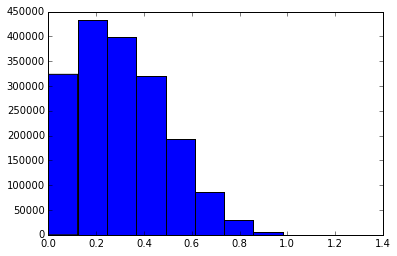

In [15]:
plt.hist(df['score'])

Funny, we might expect this distribution to be uniform.

In [91]:
df.sort('pageviews', ascending = False).head()

,name,pageviews,score
0,NASA Helios,6462135,0.827147
1,Line integral convolution,5312288,0.552656
2,Deaths in 2015,4444490,0.965520
3,Ingres (database),4302270,0.774785
4,NASA Pathfinder,4213272,0.695580


### Project Languages into 2D
We can run ALS with rank 2 and see what languages end up close to each other

In [ ]:
model = ALS.train(training, 2, iterations = 15,  lambda_ = 0.03, nonnegative=True, seed=10)

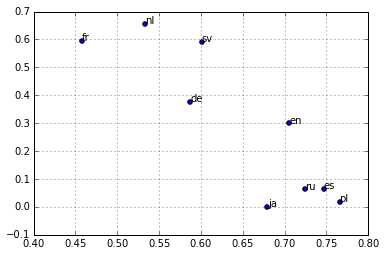

In [93]:
project(model, normalize=False)

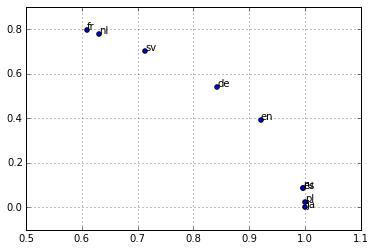

In [94]:
project(model, normalize=True)

# Log Transformation

### Transform

In [ ]:
pageviews = load_pageviews(sc, cp.get('general', 'pageviews'), k=2) 
log_pageviews = pageviews.map(lambda x: (x[0], x[1], math.log( max(1.0, x[2]))))
training, validation, test = split_train_validation_test(log_pageviews)

### Visualize Distributions

In [ ]:
views = training.filter(lambda x: x[0] == 0).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

In [ ]:
views = training.filter(lambda x: x[0] == 1).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

In [ ]:
views = training.filter(lambda x: x[0] == 2).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

In [ ]:
views = training.filter(lambda x: x[0] == 3).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

In [ ]:
views = training.filter(lambda x: x[0] == 4).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

In [ ]:
views = training.filter(lambda x: x[0] == 5).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

In [ ]:
views = training.filter(lambda x: x[0] == 6).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

In [ ]:
views = training.filter(lambda x: x[0] == 7).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

In [ ]:
views = training.filter(lambda x: x[0] == 8).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

### Compute Baseline (mean "user" rating)

In [ ]:
print_baseline(training, validation, test)

### CV 

In [112]:
ranks = [2]
numIters = [15]
lambdas = [0.001, 0.01, 0.05, 0.1, 1.0]
model, cv_results = cross_validation(training, validation, test, pageviews, ranks, lambdas, numIters)

RMSE (validation) = 0.960728 for the model trained with rank = 2, lambda = 0.0010, and numIter = 15.
RMSE (validation) = 0.907979 for the model trained with rank = 2, lambda = 0.0100, and numIter = 15.
RMSE (validation) = 0.805965 for the model trained with rank = 2, lambda = 0.0500, and numIter = 15.
RMSE (validation) = 0.755540 for the model trained with rank = 2, lambda = 0.1000, and numIter = 15.
RMSE (validation) = 1.237602 for the model trained with rank = 2, lambda = 1.0000, and numIter = 15.
The best model was trained with rank = 2 and lambda = 0.1, and numIter = 15, and its RMSE on the test set is 0.766996.
The best model improves the baseline by 59.21%.


In [120]:
ranks = [1]
numIters = [15]
lambdas = [0.001, 0.01, 0.05, 0.1, 1.0]
model, cv_results = cross_validation(training, validation, test, pageviews, ranks, lambdas, numIters)

RMSE (validation) = 0.762301 for the model trained with rank = 1, lambda = 0.0010, and numIter = 15.
RMSE (validation) = 0.761977 for the model trained with rank = 1, lambda = 0.0100, and numIter = 15.
RMSE (validation) = 0.761811 for the model trained with rank = 1, lambda = 0.0500, and numIter = 15.
RMSE (validation) = 0.764644 for the model trained with rank = 1, lambda = 0.1000, and numIter = 15.
RMSE (validation) = 1.237599 for the model trained with rank = 1, lambda = 1.0000, and numIter = 15.
The best model was trained with rank = 1 and lambda = 0.1, and numIter = 15, and its RMSE on the test set is 0.768265.
The best model improves the baseline by 59.20%.


A rank 1 approximation means that articles have the same ranking within each language. Not really waht we were hoping for.

### Inspect Ranking of EN articles missing in ES

In [121]:
df = get_named_rankings(cp, model)

In [122]:
df.head(10)

,name,pageviews,score
31705,Massan,29756,14.309044
4516,Jeannette Bougrab,95949,13.884616
77859,Wallander (film series),14213,13.740674
34522,Charlotte Kate Fox,27971,13.718313
160,Your Lie in April,520615,13.586271
333045,Belarusian National Technical University,2658,13.574096
422181,Love Antell,1887,13.553452
19491,Telephone numbers in the Netherlands,41335,13.513248
217208,Jönssonligan,4690,13.488244
539,Ebolavirus,289408,13.424642


Looks like there are articles popular in a mix of countries among the top ranked articles

### Project Languages
We can run ALS with rank 2 and see what languages end up close to each other

In [ ]:
model = ALS.train(training, 2, iterations = 15,  lambda_ = 0.1, nonnegative=True, seed=10)

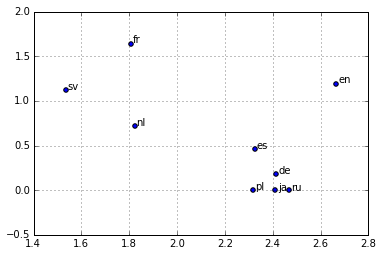

In [118]:
project(model, normalize=False)

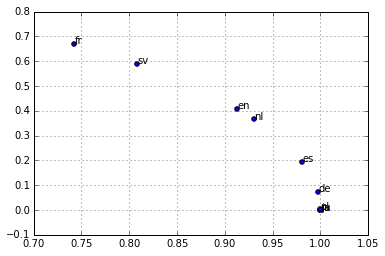

In [119]:
project(model, normalize=True)

# Log + Normalize Rows Transformarion

### Transform

In [3]:
log_pageviews = pageviews.map(lambda x: (x[0], x[1], math.log( max(1.0, x[2]))))
user_normalization_constants = dict(log_pageviews.map(lambda x: (x[0], x[2])).reduceByKey(add).collect())
print "NORMALIZATION CONSTANTS"
pprint(user_normalization_constants)
scale_factor = 100000.0
log_norm_pageviews = log_pageviews.map(lambda x: (x[0], x[1], (scale_factor*x[2])/user_normalization_constants[x[0]]))
training, validation, test = split_train_validation_test(log_norm_pageviews)

NORMALIZATION CONSTANTS
{0: 1283274.3680199492,
 1: 824876.8370007415,
 2: 1822191.992252415,
 3: 1942522.1983824922,
 4: 1442857.9988859652,
 5: 870615.6227005838,
 6: 7148276.511896231,
 7: 475522.7798897899,
 8: 19520126.72600557,
 9: 849009.74318164,
 10: 5601472.116897765,
 11: 486536.93133752095,
 12: 770878.969864824,
 13: 1810230.404632581,
 14: 1567065.1184316038,
 15: 7297792.113842766,
 16: 418793.78740939574,
 17: 818899.7672508179,
 18: 222747.4863513178,
 19: 664303.4283956548,
 20: 1234459.8293599507,
 21: 417557.002951532,
 22: 1376606.4656990014,
 23: 5383511.9371520635,
 24: 3429025.4491606653,
 25: 488949.09796738153,
 26: 1305452.8037772526,
 27: 579597.5006949981,
 28: 902200.4728538175,
 29: 6034493.722228437,
 30: 500527.21931090945,
 31: 1659568.2553648346,
 32: 4918285.717750386,
 33: 3822871.5719993287,
 34: 1178565.4024863124,
 35: 5497200.366284942,
 36: 1140182.139212952,
 37: 596103.5223647095,
 38: 834159.562745137,
 39: 538091.3709804573,
 40: 1339196.26

### Visualize Distributions

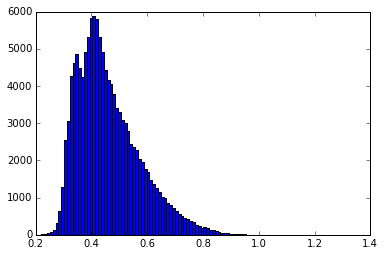

In [4]:
#16368997
views = training.filter(lambda x: x[0] == 0).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

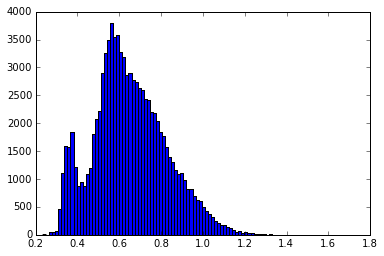

In [5]:
views = training.filter(lambda x: x[0] == 1).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

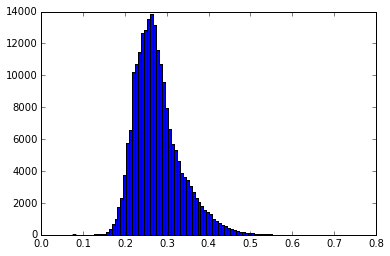

In [6]:
views = training.filter(lambda x: x[0] == 2).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

### Compute Baseline (mean "user" rating)

In [7]:
print_baseline(training, validation, test)

Mean Ratings:
        rating
lang          
0     0.460962
1     0.648407
2     0.276877
3     0.083092
4     0.418933
5     0.664568
6     0.091310
7     1.271677
8     0.038402
9     0.528134
10    0.114503
11    1.123924
12    0.532678
13    0.286869
14    0.361677
15    0.084805
16    1.227592
17    0.764620
18    2.512973
19    0.837197
20    0.457207
21    0.914520
22    0.349467
23    0.112524
24    0.210661
25    0.769817
26    0.478909
27    0.928565
28    0.472134
29    0.073111
30    0.903103
31    0.317582
32    0.126065
33    0.153200
34    0.450536
35    0.122163
36    0.371863
37    0.917354
38    0.600193
39    0.958662
40    0.342320
41    0.058993
42    0.526693
43    0.234960
44    1.033018
45    0.104070
46    0.079939
47    0.191165
48    0.519576
49    0.855067
RMSE (test):  0.091082


### CV

In [8]:
ranks = [1,2,3]
numIters = [15]
lambdas = [0.0001, 0.0005, 0.001, 0.005, 0.1]
model, cv_results = cross_validation(training, validation, test, pageviews, ranks, lambdas, numIters)

RMSE (validation) = 0.051416 for the model trained with rank = 1, lambda = 0.0001, and numIter = 15.
RMSE (validation) = 0.063126 for the model trained with rank = 2, lambda = 0.0001, and numIter = 15.
RMSE (validation) = 0.063391 for the model trained with rank = 3, lambda = 0.0001, and numIter = 15.
RMSE (validation) = 0.051049 for the model trained with rank = 1, lambda = 0.0005, and numIter = 15.
RMSE (validation) = 0.057553 for the model trained with rank = 2, lambda = 0.0005, and numIter = 15.
RMSE (validation) = 0.065193 for the model trained with rank = 3, lambda = 0.0005, and numIter = 15.
RMSE (validation) = 0.051008 for the model trained with rank = 1, lambda = 0.0010, and numIter = 15.
RMSE (validation) = 0.056205 for the model trained with rank = 2, lambda = 0.0010, and numIter = 15.
RMSE (validation) = 0.068445 for the model trained with rank = 3, lambda = 0.0010, and numIter = 15.
RMSE (validation) = 0.054571 for the model trained with rank = 1, lambda = 0.0050, and numI

### Inspect Ranking of EN articles missing in ES

In [9]:
df = get_named_rankings(cp, model)

In [11]:
df.head(100)

,id,name,en_pageviews,score
852881,1046216,Mağjan Jumabayev,975,0.306052
360358,2467249,Bauyrzhan Momyshuly,3370,0.303625
732102,2380565,Makhambet Otemisuly,1234,0.299871
142850,5645435,Hamka,9765,0.294769
2788,2913218,Contrasting and categorization of emotions,137530,0.293515
18358,466337,Mahadevi Varma,48412,0.291562
584839,1675962,Mustafa al-Siba'i,1724,0.288240
1376282,4580683,Ella Hval,437,0.288070
399010,145291,Kanysh Satbayev,2939,0.286615
1149927,1045926,Sabit Mukanov,602,0.285768


### Project Languages
We can run ALS with rank 2 and see what languages end up close to each other

In [19]:
model = ALS.train(training, 2, iterations = 15,  lambda_ = 0.001, nonnegative=True, seed=10)

/home/ellery/anaconda/lib/python2.7/site-packages/matplotlib/text.py:1857: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


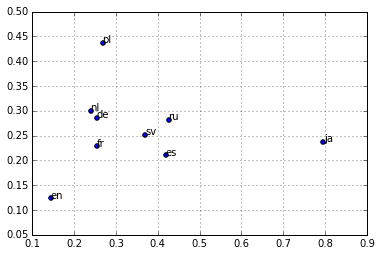

In [7]:
project(model, normalize=False)

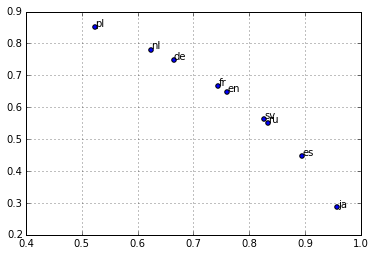

In [10]:
project(model, normalize=True)

#Scratch

In [ ]:
def print_baseline_distributed(training, validation, test):
    numTest = test.count()  
    
    sumUserRatings = training.union(validation)\
    .map(lambda x: (x[0], x[2]))\
    .reduce(add)
    
    numUserRatings = training.union(validation)\
    .map(lambda x: (x[0], 1.0))\
    .reduce(add)
    
    meanUserRatings = sumUserRatings.join(numUserRatings).map(lambda x: (x[0], x[1][0]/x[1][1]))
    meanUserRatings = dict(meanUserRatings.collect())
    baselineRmse = sqrt(test.map(lambda x: (meanUserRatings[x[0]] - x[2]) ** 2).reduce(add) / numTest)
    
    print "Mean Ratings:"
    pprint(meanUserRatings)
    
    print "RMSE (test):  %f" % baselineRmse
    

In [29]:
def to_libsvm(x):
    line = x[0][1:] + ' '
    langs = [str(lang2id[d['lang']]) + ':' + d['pageview_count'] for d in x[1]]
    langs.sort()
    return line + ' '.join(langs)
    
names = [ 'id', 'lang', 'title', 'pageview_count']

k = 3

pageviews = sc.textFile(cp.get('general', 'pageviews'))\
.map(get_parser(names))\
.filter(lambda x: len(x) == 4)\
.filter(lambda x: x['lang'] in languages_set)\
.map(lambda x: (x['id'], x))\
.groupByKey().filter(lambda x: len(x[1]) >=k ).map(to_libsvm)

In [30]:
exp_dir = 'importance'
fname = 'libsvm.txt'
base_dir = os.path.join(cp.get('general', 'local_data_dir'), exp_dir)
hadoop_base_dir = os.path.join(cp.get('general', 'hadoop_data_dir'), exp_dir)
save_rdd(pageviews, base_dir , hadoop_base_dir, fname)

256
0
256
256
0
0
0
0


In [37]:
from sklearn.datasets import load_svmlight_file
X, Y= load_svmlight_file(os.path.join(base_dir, fname))

In [44]:
X = X.T
from sklearn.preprocessing import normalize
X = normalize(X, norm='l2', axis=1, copy=True)

In [45]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X.T.toarray())
print(pca.explained_variance_ratio_) 

[ 0.97762391  0.00994535  0.00675686]


In [41]:
X

<1254410x7 sparse matrix of type '<type 'numpy.float64'>'
	with 5373355 stored elements in Compressed Sparse Row format>